# Travelling Salesman Problem

This is an homework of Artificial inteligence.

The homework is to code the travelling salesman problem using genetic algorithm.

Group:
- Hendy Rodrigues F. Silva

Id: 1510081

**Homework by Professor Aragão Junior**




### Definitions and auxiliar variables

In [1]:
import numpy as np
import random
from random import *
import matplotlib.pyplot as plt

coord_x_file = open("data/coordenadasx.dat","r")
coord_y_file = open("data/coordenadasy.dat","r")

coord_x = coord_x_file.readlines()
coord_x = list(map(lambda x: int(x.strip()) ,coord_x))

coord_y = coord_y_file.readlines()
coord_y = list(map(lambda y: int(y.strip()) ,coord_y))

cities = list(zip(coord_x, coord_y))

amount_select = 256 # deve ser divisivel por 4

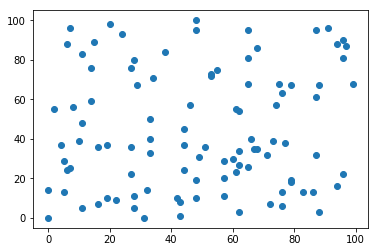

In [2]:
plt.scatter(coord_x, coord_y)

### Auxiliar functions

In [3]:
def euclidian(city_from, city_to):
    return np.sqrt((city_to[0]-city_from[0])**2 + (city_to[1]-city_from[1])**2)

In [4]:
mapCity = []
for city1 in cities:
    temp = []
    for city2 in cities:
        temp.append(euclidian(city1,city2))
    mapCity.append(temp)

In [5]:
def fitness_func(list_cities_enum, cities):
    sum_euclidian = 0
    aux_city = -1
    for i_city in list_cities_enum:
        if aux_city != -1:
            sum_euclidian += mapCity[aux_city][i_city]
            #sum_euclidian += euclidian(cities[aux_city],cities[i_city])
        aux_city = i_city
    return sum_euclidian

In [6]:
def create_random_paths(cities_e):
    paths = []
    
    for sel in range(0,amount_select):
        path =[i for i in range(len(cities_e))]
        shuffle(path) #function that randomize lists
        path.remove(0)
        path.insert(0,0)
        path.append(0)
        paths.append(path)
    return paths

In [7]:
def ride_roulette(selecteds):
    values = []
    #Montar Roleta
    #auxAccu = 0
    for path in selecteds:
        fitness = fitness_func(path,cities)
        #auxAccu += fitness
        values.append((path,fitness))
        #valuesAccu.append(auxAccu)

    # Calcular porcentagens
    calcPerc = lambda x: (1/x)/sum([1/val[1] for val in values])

    auxAccu = 0
    for i, path in enumerate(values):
        auxAccu += calcPerc(path[1])
        values[i] = path + (calcPerc(path[1]), auxAccu)
    return values

In [8]:
def spin_roulette(generation):
    rnd = random()
    choose = list(filter(lambda q: q[3] > rnd, generation))
    return min(choose,key=lambda x: x[3])

In [9]:
def crossover(parent_one, parent_two):
    
    #Choose the 2 borders randomly
    limits_one = sorted(sample(range(2,len(cities)-1),2))
    limits_two = sorted(sample(range(2,len(cities)-1),2))
    
    #Get only core of each
    core_one = [x for i, x in enumerate(parent_one) if i >= limits_one[0] and i <= limits_one[1]]
    core_two = [x for i, x in enumerate(parent_two) if i >= limits_two[0] and i <= limits_two[1]]
    
    mount_one = []
    mount_two = []
    
    
    i = 0
    aux = 0
    
    #Algorithm used: OX - Ordered Crossove
    
    # Generate first descedent
    while i < len(parent_one):
        if i < limits_one[0] or i > limits_one[1]:
            while (parent_two[aux] in core_one):
                aux += 1
            mount_one.append(parent_two[aux])
            aux += 1
        else:
            mount_one.append(parent_one[i])
        
        i += 1
    
    aux = 0
    n = 0
    
    
    # Generate second descedent
    while n < len(parent_two):
        if n < limits_two[0] or n > limits_two[1]:
            while (parent_one[aux] in core_two):
                aux += 1
            mount_two.append(parent_one[aux])
            aux += 1
        else:
            mount_two.append(parent_two[n])
        
        n += 1
    return (mount_one, mount_two)

In [10]:
def mutation(child):
    for i in range(1,len(child)-1):
        if random() >= 0.95:
            pos = randrange(1, len(child)-1)
            aux = child[i]
            child[i] = child[pos]
            child[pos] = aux
    return child
            

In [11]:
def new_generate_second_method(selecteds):
    #calcPerc = lambda x: (1/x)/sum([1/val[1] for val in values])
    
    new_gen = sorted(selecteds, key=lambda x: fitness_func(x,cities))
    #B = A[:len(A)//2]
    new_gen = new_gen[:len(new_gen)//2]
    new_child = []
    
    shuffle(new_gen)
    
    i = 0
    while i < len(new_gen):
        new_child_1, new_child_2 = crossover(new_gen[i], new_gen[i+1])
        new_child.append(new_child_1)
        new_child.append(new_child_2)
        
        mutation(new_gen[i])
        mutation(new_gen[i+1])
        mutation(new_child_1)
        mutation(new_child_2)
        i += 2
        
    #for path in new_gen:
        #fitness = fitness_func(path,cities)
        #new_ge2n.append((path,fitness))

    # Calcular porcentagens
    
    new_li = new_gen + new_child
    
    
    
    return new_li

In [12]:
def create_new_generation(selecteds):
    i = 0
    new_generation = []
    while i < len(selecteds):
        parent_one = selecteds[i]
        parent_two = selecteds[i+1]
        
        child_one, child_two = crossover(parent_one, parent_two)
        
        #Mutante
        child_one = mutation(child_one)
        child_two = mutation(child_two)
        
        new_generation.append(child_one)
        new_generation.append(child_two)
        
        i += 2
        
    return new_generation

### População

In [13]:
population = create_random_paths(cities)
history_fitness_func = []

for i in range(0, 1000000):
    #roulette = ride_roulette(population)
    #new_selects = [spin_roulette(roulette)[0] for i in range(0, amount_select)]
    #population = create_new_generation(new_selects)
    population = new_generate_second_method(population)
    t = fitness_func(min(population, key=lambda x: fitness_func(x,cities)),cities)
    history_fitness_func.append(t)
    #print(t)
    

In [14]:
fitness_func(min(population, key=lambda x: fitness_func(x,cities)),cities)

4317.43854157294

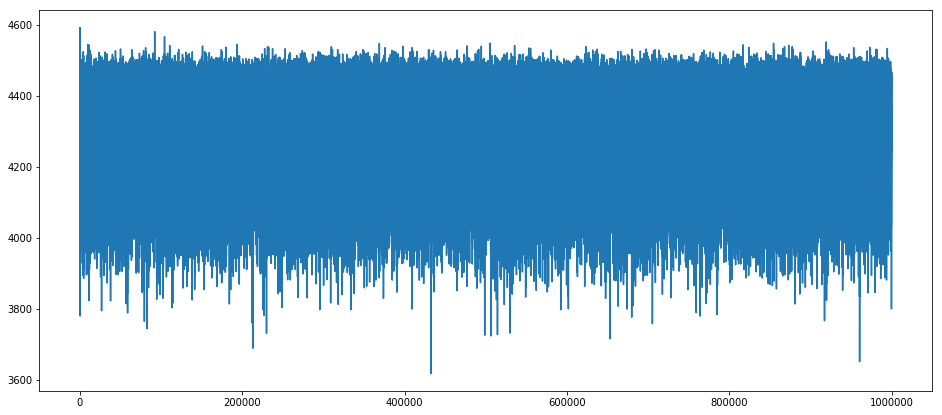

In [15]:
fig = plt.figure(figsize=(16,7))
ax = fig.add_subplot(1, 1, 1)
ax.plot(history_fitness_func)

In [16]:
history_fitness_func

[4440.207197021391,
 4592.660774194613,
 4575.363489512009,
 4558.174361382137,
 4492.56545315468,
 4509.8085638511675,
 4439.206102162187,
 4449.6695065070235,
 4141.351136521531,
 4091.3726354165383,
 4180.644437374051,
 4320.146818542068,
 4336.977568123727,
 4465.431256790551,
 4409.2726908399445,
 4398.318299341728,
 4322.0016498203095,
 4222.381818461684,
 4271.916220527437,
 4373.407653503518,
 4317.690783041448,
 4424.238100883199,
 4189.920459589711,
 4417.0044078276405,
 4437.405852498026,
 4330.1715262975495,
 4329.0837816680705,
 4480.886314602076,
 4345.726132819915,
 4387.814700123081,
 4363.7970139270365,
 4365.891899492435,
 4231.50087190998,
 4289.148089164393,
 4256.4830312888325,
 4280.831584551687,
 4252.415209028851,
 4294.065094352001,
 4387.034035904552,
 4367.7923278899125,
 4218.358287725645,
 4241.891011739456,
 4317.5301940427025,
 4055.4985015690763,
 4066.3791815071736,
 4222.183359742807,
 4224.069861947363,
 4268.082272513333,
 4301.562923349002,
 4250.80